# 基于梯度的优化

>本文内容：
1.什么是梯度下降方法？
2.反向传播算法（BP算法）

## 1.为什么要梯度优化
上一节介绍过，我们的第一个神经网络示例中，每个神经层都用下述方法对输入数据进行 变换。
```
output = relu(dot(W, input) + b)
```
在这个表达式中，W 和 b 都是张量，均为该层的属性。它们被称为该层的`权重(weight)`或 `可训练参数(trainable parameter)`，分别对应 kernel 和 bias 属性。

这些权重包含网络从观察 训练数据中学到的信息。

一开始，这些权重矩阵取较小的随机值，这一步叫作`随机初始化(random initialization)`。 

当然，W 和 b 都是随机的，relu(dot(W, input) + b) 肯定不会得到任何有用的表示。

虽然得到的表示是没有意义的，但这是一个起点。下一步则是根据反馈信号逐渐调节这些权重。这个逐渐调节的过程叫作训练，也就是机器学习中的学习。

上述过程发生在一个训练循环(training loop)内，其具体过程如下。必要时一直重复这些步骤。

>(1) 抽取训练样本x和对应目标y组成的数据批量。
(2) 在 x 上运行网络[这一步叫作前向传播(forward pass)]，得到预测值 y_pred。
(3) 计算网络在这批数据上的损失，用于衡量y_pred和y之间的距离。
(4) 更新网络的所有权重，使网络在这批数据上的损失略微下降。

最终得到的网络在训练数据上的损失非常小，即预测值 y_pred 和预期目标 y 之间的距离非常小。网络“学会”将输入映射到正确的目标。乍一看可能像魔法一样，但如果你将其简化为基本步骤，那么会变得非常简单。

第一步看起来非常简单，只是输入 / 输出(I/O)的代码。第二步和第三步仅仅是一些张量运算的应用，所以你完全可以利用上一节学到的知识来实现这两步。
*难点在于第四步:更新网络的权重，也就是著名的BP误差逆传播算法。*

考虑网络中某个权重系数，你怎么知道这个系数应该增大还是减小，以及变化多少?
就像我们开车，上一秒车头往左偏了30度，接下来我们要计算下一秒方向盘向右打多少度才能板正车头？

一种简单的解决方案是，保持网络中其他权重不变，只考虑某个标量系数，让其尝试不同 的取值。假设这个系数的初始值为 0.3。对一批数据做完前向传播后，网络在这批数据上的损失 是 0.5。如果你将这个系数的值改为 0.35 并重新运行前向传播，损失会增大到 0.6。但如果你将 这个系数减小到 0.25，损失会减小到 0.4。在这个例子中，将这个系数减小 0.05 似乎有助于使
损失最小化。对于网络中的所有系数都要重复这一过程。

但这种方法是非常低效的，因为对每个系数(系数很多，通常有上千个，有时甚至多达上 3
百万个)都需要计算两次前向传播(计算代价很大)。一种更好的方法是利用网络中所有运算都是`可微(differentiable)`的这一事实，计算损失相对于网络系数的`梯度(gradient)`，然后向梯度的反方向改变系数，从而使损失降低。
## 2.导数derivative 和梯度 gradient
### 导数
导数这个概念我们都不陌生，在微积分里学过，下面我们简单回忆一下导数的概念。

假设有一个连续的光滑函数 f(x) = y，将实数 x 映射为另一个实数 y。由于函数是连续的， x 的微小变化只能导致 y 的微小变化——这就是函数连续性的直观解释。假设 x 增大了一个很小的因子epsilon_x，这导致 y 也发生了很小的变化，即 epsilon_y:
f(x + epsilon_x) = y + epsilon_y
此外，由于函数是光滑的(即函数曲线没有突变的角度)，在某个点 p 附近，如果 epsilon_x 足够小，就可以将 f 近似为斜率为 a 的线性函数，这样epsilon_y 就变成了 a * epsilon_x:
f(x + epsilon_x) = y + a * epsilon_x
显然，只有在 x 足够接近 p 时，这个线性近似才有效。
斜率 a 被称为 f 在 p 点的导数(derivative)。如果 a 是负的，说明 x 在 p 点附近的微小变 7 化将导致 f(x) 减小(如图 2-10 所示);如果 a 是正的，那么 x 的微小变化将导致 f(x) 增大。 此外，a 的绝对值(导数大小)表示增大或减小的速度快慢。
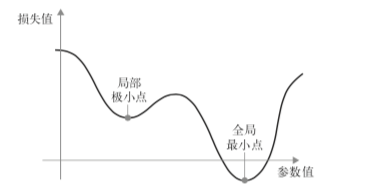
对于每个可微函数 f(x)(可微的意思是“可以被求导”。例如，光滑的连续函数可以被求导)， 都存在一个导数函数 f'(x)，将 x 的值映射为 f 在该点的局部线性近似的斜率。例如，cos(x) 的导数是 -sin(x)，f(x) = a * x 的导数是 f'(x) = a，等等。

那么思路就有了，如果你想要将权重w改变一个小因子 epsilon_w，目的是将 f(w) 最小化，并且知道 f 的导数， 那么问题解决了:导数完全描述了改变 w 后 f(w) 会如何变化。如果你希望减小 f(w) 的值，只需将 w 沿着导数的反方向移动一小步（至于一小步是多小，需要根据不同任务自行衡量，也就是损失函数）。
也就是使
w=w+delta_w
delta_W=误差plus（负的导数）plus比率
### 梯度
一元函数叫导数，多元函数的导数就叫梯度。衡量整个多元函数的变化趋势。
`梯度(gradient)`是张量运算的导数。它是导数这一概念向多元函数导数的推广。多元函数是以张量作为输入的函数。
假设有一个输入向量 x、一个矩阵 W、一个目标 y 和一个损失函数 loss。你可以用 W 来计 算预测值 y_pred，然后计算损失，或者说预测值 y_pred 和目标 y 之间的距离。
```
y_pred = dot(W, x) 
loss_value = loss(y_pred, y)
```
如果输入数据 x 和 y 保持不变，那么这可以看作将 W 映射到损失值的函数。 loss_value = f(W)
假设 W 的当前值为 W0。f 在 W0 点的导数是一个张量 gradient(f)(W0)，其形状与 W 相同， 每个系数 gradient(f)(W0)[i, j] 表示改变 W0[i, j] 时 loss_value 变化的方向和大小。 张量 gradient(f)(W0) 是函数 f(W) = loss_value 在 W0 的导数。
前面已经看到，单变量函数 f(x) 的导数可以看作函数 f 曲线的斜率。同样，gradient(f) (W0) 也可以看作表示 f(W) 在 W0 附近`曲率(curvature)的张量。`
对于一个函数 f(x)，你可以通过将 x 向导数的反方向移动一小步来减小 f(x) 的值。
同样，对于张量的函数 f(W)，你也可以通过将 W 向梯度的反方向移动来减小 f(W)，比如 W1 = W0 - step * gradient(f)(W0)，其中 step 是一个很小的比例因子。也就是说，沿着曲 率的反方向移动，直观上来看在曲线上的位置会更低。
注意，比例因子 step 是必需的，因为 gradient(f)(W0) 只是 W0 附近曲率的近似值，不能离 W0 太远。
## 3.随机梯度下降
给定一个可微函数，理论上可以用解析法找到它的最小值:函数的最小值是导数为 0 的点， 因此你只需找到所有导数为 0 的点，然后计算函数在其中哪个点具有最小值。
将这一方法应用于神经网络，就是用解析法求出最小损失函数对应的所有权重值。可以通 过对方程 gradient(f)(W) = 0 求解 W 来实现这一方法。这是包含 N 个变量的多项式方程， 其中 N 是网络中系数的个数。N=2 或 N=3 时可以对这样的方程求解，但对于实际的神经网络是 无法求解的，因为参数的个数不会少于几千个，而且经常有上千万个。
相反，你可以使用前面总结的四步算法:基于当前在随机数据批量上的损失，一点一点地对参数进行调节。由于处理的是一个可微函数，你可以计算出它的梯度，从而有效地实 现第四步。沿着梯度的反方向更新权重，损失每次都会变小一点。

>(1) 抽取训练样本x和对应目标y组成的数据批量。
(2) 在x上运行网络，得到预测值y_pred。
(3) 计算网络在这批数据上的损失，用于衡量y_pred和y之间的距离。
(4) 计算损失相对于网络参数的梯度[一次反向传播(backward pass)]。
(5) 将参数沿着梯度的反方向移动一点，比如 W -= step * gradient，从而使这批数据
上的损失减小一点。

这很简单!我刚刚描述的方法叫作`小批量随机梯度下降(mini-batch stochastic gradient descent，又称为小批量 SGD)`。术语随机(stochastic)是指每批数据都是随机抽取的(stochastic 是 random 3 在科学上的同义词，下图给出了一维的情况，网络只有一个参数，并且只有一个训练样本
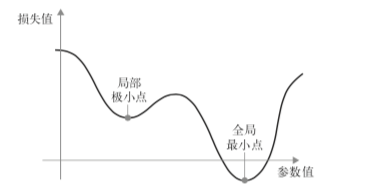

如你所见，直观上来看，为 step 因子选取合适的值是很重要的。如果取值太小，则沿着 曲线的下降需要很多次迭代，而且可能会陷入局部极小点。如果取值太大，则更新权重值之后 可能会出现在曲线上完全随机的位置。
注意，小批量 SGD 算法的一个变体是每次迭代时只抽取一个样本和目标，而不是抽取一批 数据。这叫作`真 SGD(有别于小批量 SGD)`。还有另一种极端，每一次迭代都在所有数据上运行，这叫作`批量SGD`。这样做的话，每次更新都更加准确，但计算代价也高得多。这两个极端之间的有效折中则是选择合理的批量大小。
也就是说，我们从数据集中抽取了一个批次（batchsize）的数据，经过神经网络一个前向传播后，再根据输出结果的误差，从梯度负方向更新前一层参数，依次向前直到更新完整个网络的权重，比如说，前面的mnist数据集，batchsize为128，输入的就是一个二维的张量（128，784），然后从最后向前，对张量求梯度，然后反向传播

上图描述的是一维参数空间中的梯度下降，但在实践中需要在高维空间中使用梯度下降。 神经网络的每一个权重参数都是空间中的一个自由维度，网络中可能包含数万个甚至上百万个 参数维度。为了让你对损失曲面有更直观的认识，你还可以将梯度下降沿着二维损失曲面可视化， 如下图所示。但你不可能将神经网络的实际训练过程可视化，因为你无法用人类可以理解的 方式来可视化 1 000 000 维空间。因此最好记住，在这些低维表示中形成的直觉在实践中不一定 总是准确的。这在历史上一直是深度学习研究的问题来源。

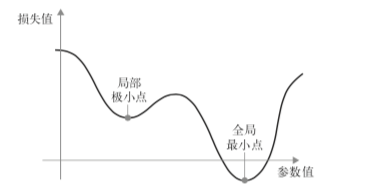
此外，SGD 还有多种变体，其区别在于计算下一次权重更新时还要考虑上一次权重更新， 而不是仅仅考虑当前梯度值，比如带动量的 SGD、Adagrad、RMSProp 等变体。这些变体被称 为优化方法(optimization method)或优化器(optimizer)。其中动量的概念尤其值得关注，它在 许多变体中都有应用。动量解决了 SGD 的两个问题:收敛速度和局部极小点。下图给出了 损失作为网络参数的函数的曲线。
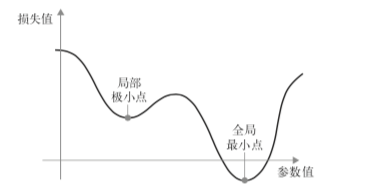
如你所见，在某个参数值附近，有一个`局部极小点(local minimum)`:在这个点附近，向 左移动和向右移动都会导致损失值增大。如果使用小学习率的 SGD 进行优化，那么优化过程可 能会陷入局部极小点，导致无法找到全局最小点。

使用动量方法可以避免这样的问题，这一方法的灵感来源于物理学。有一种有用的思维图像， 就是将优化过程想象成一个小球从损失函数曲线上滚下来。如果小球的动量足够大，那么它不会 卡在峡谷里，最终会到达全局最小点。动量方法的实现过程是每一步都移动小球，不仅要考虑当 前的斜率值(当前的加速度)，还要考虑当前的速度(来自于之前的加速度)。这在实践中的是指， 更新参数 w 不仅要考虑当前的梯度值，还要考虑上一次的参数更新，其简单实现如下所示。
```
past_velocity = 0.
momentum = 0.1 不变的动量因子 
while loss > 0.01: 优化循环
w, loss, gradient = get_current_parameters()
velocity = past_velocity * momentum - learning_rate * gradient w = w + momentum * velocity - learning_rate * gradient past_velocity = velocity
update_parameter(w)
```
# 链式求导:反向传播算法(BP算法）
在前面的算法中，我们假设函数是可微的，因此可以明确计算其导数。在实践中，神经网 络函数包含许多连接在一起的张量运算，每个运算都有简单的、已知的导数。例如，下面这个 网络f包含 3 个张量运算a、b和c，还有 3 个权重矩阵W1、W2和W3。
f(W1, W2, W3) = a(W1, b(W2, c(W3)))

根据微积分的知识，这种函数链可以利用下面这个恒等式进行求导，它称为`链式法则(chain rule)`:(f(g(x)))' = f'(g(x)) * g'(x)。将链式法则应用于神经网络梯度值的计算，得到的算法叫作反向传播(backpropagation，有时也叫反式微分，reverse-mode differentiation)。反向传播从最终损失值开始，从最顶层反向作用至最底层，利用链式法则计算每个参数对损失值的贡献大小。

随着深度学习框架的普及，人们将使用能够进行`符号微分(symbolic differentiation)`的现代框架来 实现神经网络，比如 TensorFlow。也就是说，给定一个运算链，并且已知每个运算的导数，这 些框架就可以利用链式法则来计算这个运算链的梯度函数，将网络参数值映射为梯度值。对于这样的函数，反向传播就简化为调用这个梯度函数。由于符号微分的出现，你无须手动实现反向传播算法。

如果你希望了解BP反向传播的具体数学推导，可以看我的这篇文章

# 回顾
已经看完了梯度下降和反向传播，现在应该对神经网络背后的原理有了大致的了解。我们回头 看一下第一个例子，并根据前面三节学到的内容来重新阅读这个例子中的每一段代码。
下面是输入数据。
```
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
train_images = train_images.reshape((60000, 28 * 28)) train_images = train_images.astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)) test_images = test_images.astype('float32') / 255
```
现在你明白了，输入图像保存在 float32 格式的 Numpy 张量中，形状分别为 (60000, 784)(训练数据)和 (10000, 784)(测试数据)。

下面是构建网络。
```
network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,))) network.add(layers.Dense(10, activation='softmax'))
```
现在你明白了，这个网络包含两个 Dense(全联接）层，每层都对输入数据进行一些简单的张量运算， 这些运算都包含权重张量。权重张量是该层的属性，里面保存了网络所学到的知识(knowledge)。

下面是网络的编译。
```
network.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])
```
现在你明白了，categorical_crossentropy 是损失函数，是用于学习权重张量的反馈 信号，在训练阶段应使它最小化。你还知道，减小损失是通过小批量随机梯度下降来实现的。 梯度下降的具体方法由第一个参数给定，即 rmsprop 优化器。

最后，下面是训练循环。
```
network.fit(train_images, train_labels, epochs=5, batch_size=128)
```
现在你明白在调用 fit 时发生了什么:网络开始在训练数据上进行迭代(每个小批量包含 128 个样本)，共迭代 5 次[在所有训练数据上迭代一次叫作一个轮次(epoch)]。在每次迭代 过程中，网络会计算批量损失相对于权重的梯度，并相应地更新权重。5 轮之后，网络进行了 2345 次梯度更新(每轮 469 次)，网络损失值将变得足够小，使得网络能够以很高的精度对手 写数字进行分类。
到目前为止，你已经了解了神经网络的大部分知识。

最后我们明白了，神经网络通过存储权重的方式学习的知识，我们通过反向传播方法（一般采取梯度下降方法）来训练其中的权重，训练完成后，我们就不需要再使用反向传播来，直接将任务输入神经网络，就可以得到结果了。

这个过程就类似我们上学考试，平常我们做试卷，然后对答案，知道自己的结果和答案的偏差以后纠正自己的知识。最后考试的时候我们就只做试卷就可以了。

# 参考文献
> [1]《机器学习》周志华著，清华大学出版社,2016. 
[2]  Python深度学习，（美）弗朗索瓦·肖莱，人民邮电出版社，2018，8
[3] 深度学习，[美] 伊恩·古德费洛 / [加] 约书亚·本吉奥 / [加] 亚伦·库维尔 